Short corrdior example from "Reinforcement Learning: An Introduction" page 323.

In [129]:
import jax, jax.numpy as jnp, jax.random as jr
import numpy as np, typing, pandas as pd, matplotlib.pyplot as plt
from minirl.corridor import Corridor
from tqdm import tqdm, trange

key = jr.key(0)

In [41]:
env = Corridor()

In [102]:
class Coinflip(typing.NamedTuple):
  "Bernoulli model with learnable parameter p"
  p_init: float

  def __call__(self, model_params, model_state, key, _env_state):
    assert model_state == ()
    p = model_params
    return jr.bernoulli(key, p=p)
  
  def logp(self, model_params, model_state, _env_state, action):
    assert model_state == ()
    p = model_params
    return jnp.where(action == 0, jnp.log(1 - p), jnp.log(p))
  
  def init(self, _key):
    return jnp.array(self.p_init, dtype=float), ()

In [103]:
mean_gs = []
ps = np.linspace(.05, .98, 50)
for p in tqdm(ps):
  # initialize the model
  model = Coinflip(p)
  model_params, model_state = model.init(())

  gs = []
  for _ in range(100):
    # run an episode with the model
    state = env.reset(())
    g = 0. # cumulative reward
    for i in range(100): # truncation
      key, action_key = jr.split(key)
      action = model(model_params, model_state, action_key, env.observe(state))
      state, reward, done = env.step(state, action)
      if done:
        break
      g += reward
    gs.append(g)
  gs = jnp.stack(gs)
  mean_gs.append(gs.mean().item())


100%|██████████| 50/50 [01:37<00:00,  1.94s/it]


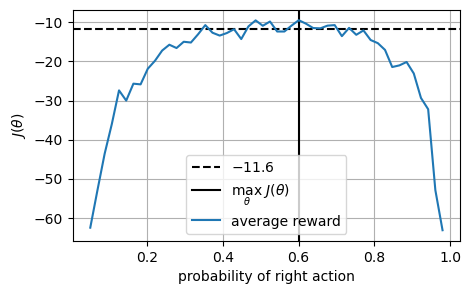

In [125]:
plt.figure(figsize=(5,3))
plt.axhline(-11.6, ls="--", c="k", label=r"$-11.6$")
plt.axvline(ps[pd.Series(mean_gs, index=ps).argmax()], c="k", label=r"$\max_\theta\ J(\theta)$")
pd.Series(mean_gs, index=ps).plot.line(
  grid=True, label="average reward", ylabel=r"$J(\theta)$", xlabel="probability of right action"
)
plt.legend();

REINFORCE: Monte-Carlo Policy-Gradient Control

In [146]:
alpha, gamma = 3e-4, .9

model = Coinflip(.3)
model_params, model_state = model.init(())
snapshots = [] # snapshots of model state

In [147]:
for _ in trange(1000):
  # generate an episode
  state = env.reset(())
  episode = []
  for i in range(100): # truncation
    key, action_key = jr.split(key)
    action = model(model_params, model_state, action_key, env.observe(state))
    newstate, reward, done = env.step(state, action)
    episode.append((state.item(), action.item(), reward.item()))
    if done:
      break
    state = newstate

  # update parameters
  for t in range(0, len(episode)):
    g = 0.
    for k in range(t, len(episode)):
      r = episode[k][2] # reward at k
      g += gamma ** (k - t) * r
    state, action, _ = episode[t]
    grad = jax.grad(model.logp)(model_params, model_state, state, action)
    model_params = model_params + alpha * gamma ** t * g * grad
  snapshots.append(model_params)

100%|██████████| 1000/1000 [00:44<00:00, 22.36it/s]


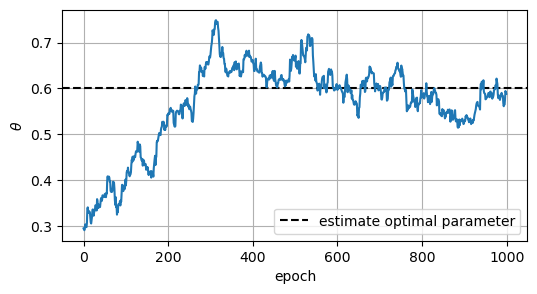

In [145]:
plt.figure(figsize=(6,3))
plt.axhline(.6, ls="--", c="k", label="estimate optimal parameter")
pd.Series(jnp.stack(snapshots)).plot.line(
  grid=True, ylabel=r"$\theta$", xlabel="epoch"
)
plt.legend();